In [1]:
from max_reward_buffer import ReplayBuffer
import os
from energies import *
from plot_utils import *
from utils import set_seed, cal_subtb_coef_matrix, fig_to_image, get_gfn_optimizer, get_gfn_forward_loss, \
    get_gfn_backward_loss, get_exploration_std, get_name

In [52]:
buffer = ReplayBuffer(600000, device='cuda', coreset_size=2000, exploration_mode=True)

In [53]:
buffer.load_buffer('buffer_np/buffer_many_well_1000_1724963379.3716211.npy')

In [54]:
buffer.get_core_set()

In [55]:
buffer.real_size

2000

In [56]:
energy_name = "many_well"

def get_energy(energy_name, device):
    if energy_name == '9gmm':
        energy = NineGaussianMixture(device=device)
    elif energy_name == '25gmm':
        energy = TwentyFiveGaussianMixture(device=device)
    elif energy_name == 'hard_funnel':
        energy = HardFunnel(device=device)
    elif energy_name == 'easy_funnel':
        energy = EasyFunnel(device=device)
    elif energy_name == 'many_well':
        energy = ManyWell(device=device)
    return energy

energy = get_energy(energy_name, 'cpu')

In [57]:
def plot_step(energy, energy_name, device = 'cpu', buffer=None, plot_size=None):
    print(buffer)
    samples, _ = buffer.sample(plot_size)

    # Visualization 및 파일 저장
    if energy_name == 'many_well':
        vizualizations = viz_many_well(energy, samples)
        fig_samples_x13, ax_samples_x13, fig_kde_x13, ax_kde_x13, fig_contour_x13, ax_contour_x13, fig_samples_x23, ax_samples_x23, fig_kde_x23, ax_kde_x23, fig_contour_x23, ax_contour_x23 = vizualizations

        fig_samples_x13.savefig(f'samplesx13.pdf', bbox_inches='tight')
        fig_samples_x23.savefig(f'samplesx23.pdf', bbox_inches='tight')

        fig_kde_x13.savefig(f'kdex13.pdf', bbox_inches='tight')
        fig_kde_x23.savefig(f'kdex23.pdf', bbox_inches='tight')

        fig_contour_x13.savefig(f'contourx13.pdf', bbox_inches='tight')
        fig_contour_x23.savefig(f'contourx23.pdf', bbox_inches='tight')

    else:
        fig_contour, ax_contour = get_figure(bounds=(-13., 13.))
        fig_kde, ax_kde = get_figure(bounds=(-13., 13.))
        fig_kde_overlay, ax_kde_overlay = get_figure(bounds=(-13., 13.))

        plot_contours(energy.log_reward, ax=ax_contour, bounds=(-13., 13.), n_contour_levels=150, device=device)
        plot_kde(samples, ax=ax_kde_overlay, bounds=(-13., 13.))
        plot_kde(samples, ax=ax_kde, bounds=(-13., 13.))
        plot_samples(samples, ax=ax_contour, bounds=(-13., 13.))
        plot_samples(samples, ax=ax_kde_overlay, bounds=(-13., 13.))

        fig_contour.savefig(f'contour.pdf', bbox_inches='tight')
        fig_kde_overlay.savefig(f'kde_overlay.pdf', bbox_inches='tight')
        fig_kde.savefig(f'kde.pdf', bbox_inches='tight')


In [58]:
buffer.sample(10)

(tensor([[-8.2241e-01, -3.5350e-02, -4.3139e-01, -2.7251e+00,  8.6449e-01,
           1.5257e+00,  1.1950e+00,  2.4958e+00, -3.0745e-01, -7.9550e-02,
          -9.9517e-01, -7.6660e-01,  1.2142e+00, -7.1333e-01,  1.2866e+00,
          -1.2324e+00, -9.6741e-01,  1.3938e+00,  2.2213e+00,  7.2161e-01,
          -1.7333e+00,  5.0049e-02,  1.4053e+00,  2.6898e+00, -1.4828e-01,
          -1.8067e+00, -1.9685e+00,  1.0415e+00, -1.0435e+00, -7.0116e-01,
          -1.3451e+00, -1.2107e+00],
         [-6.1447e-01,  8.7321e-01,  4.7131e-02, -1.3915e+00,  1.5920e+00,
          -1.1100e-01,  9.7290e-01, -6.6250e-01, -2.3042e-01,  1.1229e+00,
           1.0336e-01,  8.1189e-01,  1.5892e+00, -1.4284e+00, -1.6545e-01,
           1.8769e+00, -1.3206e+00, -7.7106e-01,  2.2240e-01, -5.8999e-01,
          -1.3695e+00, -3.9559e-02,  2.0731e+00, -8.8206e-01,  2.1898e+00,
           4.6119e-01,  2.0575e+00,  8.7187e-01,  1.0485e+00, -6.8720e-02,
           1.4745e+00, -5.7409e-01],
         [-3.4664e-02, -1.

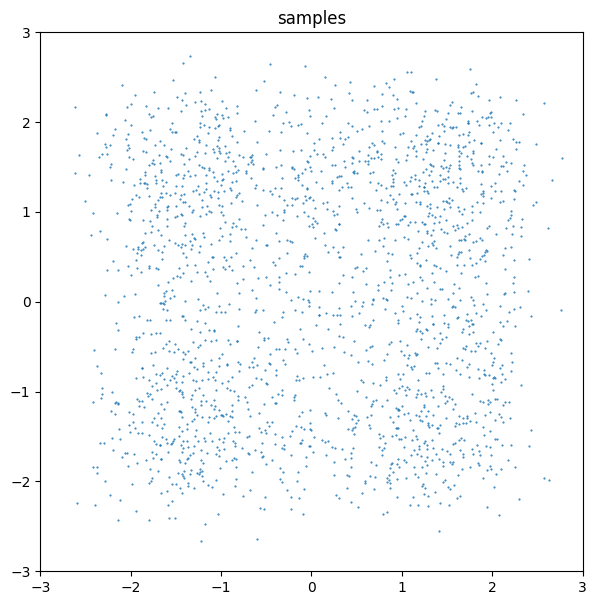

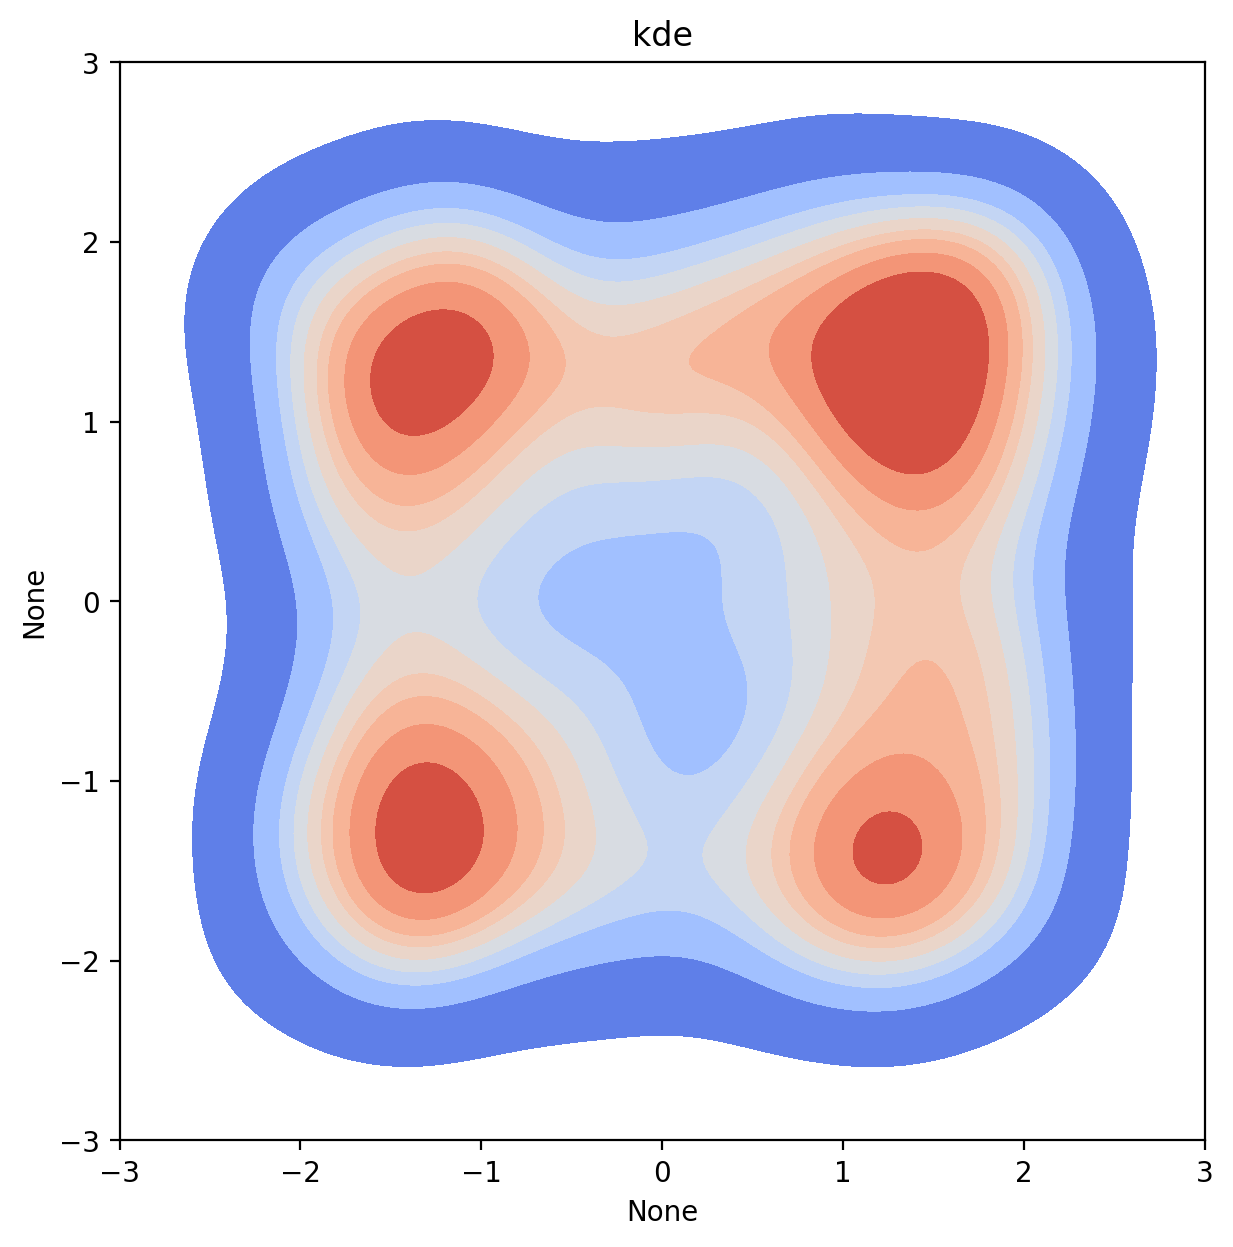

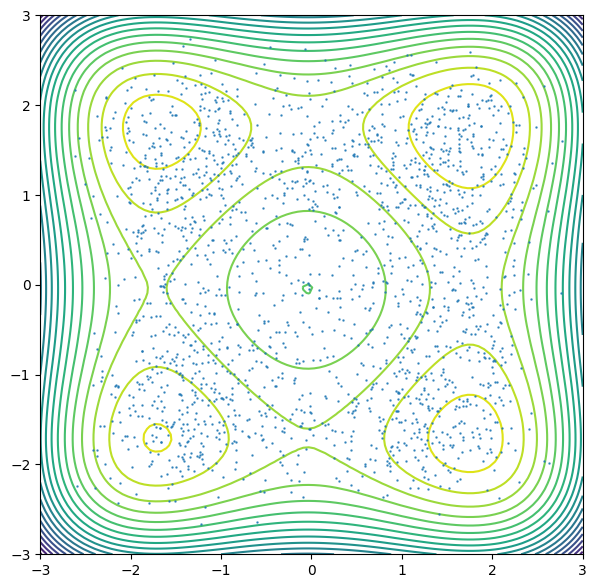

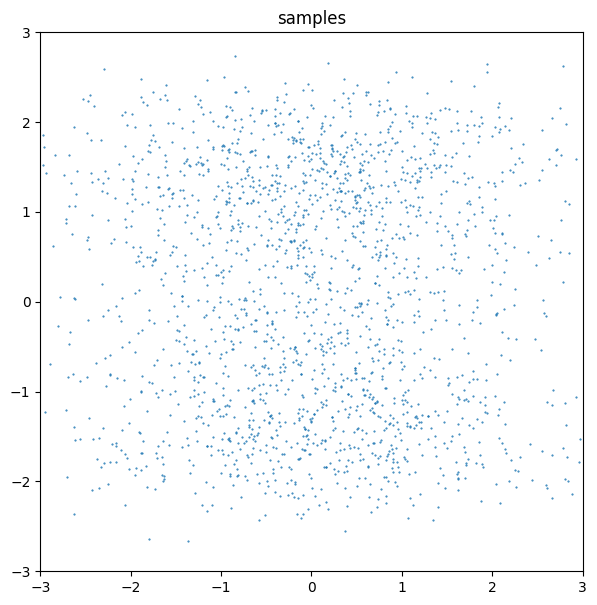

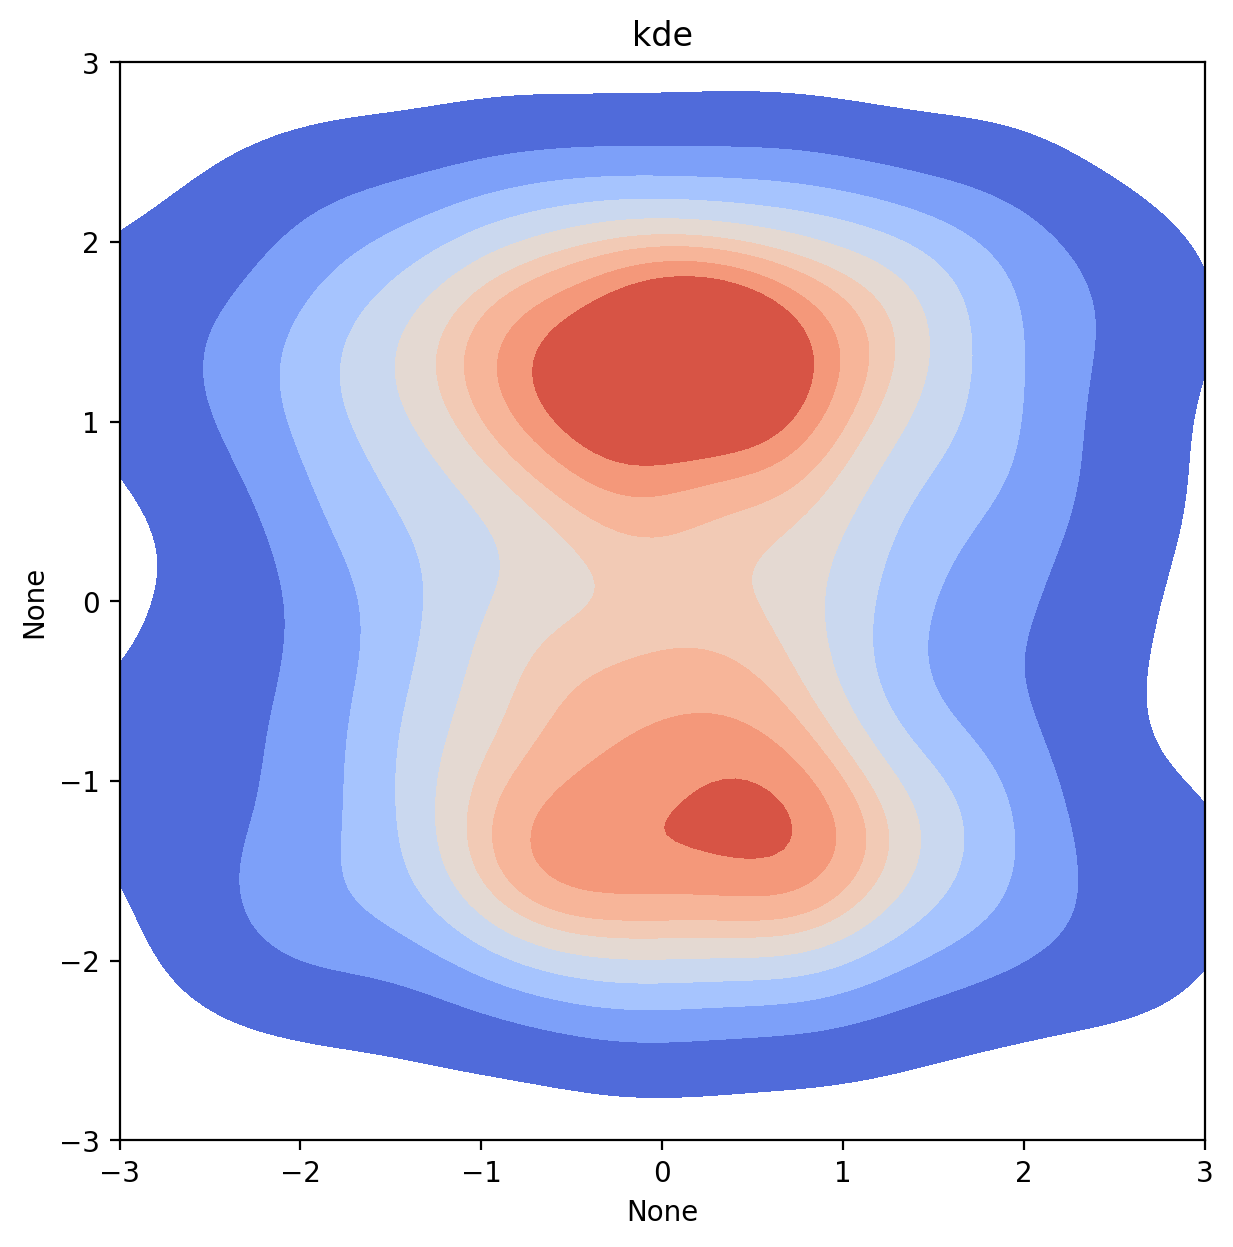

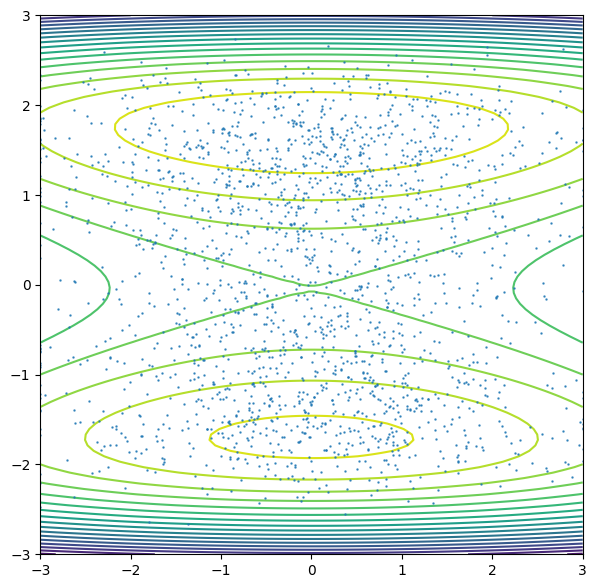

In [59]:
images_buffer = plot_step(energy, energy_name, 'cpu', buffer, 2000)
